In [1]:
import numpy as np
import pandas as pd
import os

class ModelData:
    def __init__(self, seed, intervention, latent, incub, infect, run):
        self.name = intervention
        self.seed = seed
        self.run = run
        self.gem = None
        self.gem_id = None
        self.pos = None
        self.people = None
        self.phases = None
        self.status = None
        self.timestep = None

        self.latent = latent
        self.incub = incub
        self.infect = infect

        self.exposed = None
        self.new_exposed = None
        self.infected = None
        self.new_infected = None
        self.recovered = None
        self.hospital = None

# Load data
def load_data(seed, intervention, latent, incub, infect, run):
    path = os.getcwd() + '/Data/Model_V1/Data/'

    data = ModelData(seed, intervention, latent, incub, infect, run)
    data.name = intervention
    data.seed = seed
    data.run = run
    
    data.gem = pd.read_pickle(path + 'Gemeenten.pkl')
    data.gem_id = pd.read_pickle(path +'GemeentenID.pkl')
    data.pos = np.load(path + 'Positions.npy')

    try:
        path = os.getcwd() + '/Data/Model_V1/Data/High/Seed_' + str(seed) + '/'

        data.people = pd.read_pickle(path + 'PeopleDF.pkl')

        path = path + 'Runs_' + intervention + '_' + str(latent)+ '_' + str(incub) + '_' + str(infect)

        data.phases = pd.read_pickle(path + '/Phases_' + str(run) + '.pkl')
        data.status = np.load(path + '/Status_' + str(run) + '.npz')
        data.timestep = np.loadtxt(path + '/Timestep_' + str(run))
        print("Loaded data ({}, {}, {}, params: {}, {}, {})".format(intervention, seed, run, latent, incub, infect))
    except:
        print("Error loading data ({}, {}, {}, params: {}, {}, {})".format(intervention, seed, run, latent, incub, infect))
        return

    return data

In [2]:
seeds = [3]
runs = [0]
interventions = ['ref']
latent_vals = [3,6,9]
incub_vals = [3,6,9]
infect_vals = [5]

data_points = []
for seed in seeds:
    for run in runs:
        for intervention in interventions:
            for latent in latent_vals:
                for incub in incub_vals:
                    for infect in infect_vals:
                        data_points.append(load_data(seed, intervention, latent, incub, infect, run))

data_points = list(filter(None, data_points))
print('Succesfully loaded ' + str(len(data_points)) + ' data points')

Loaded data (ref, 3, 0, params: 3, 3, 5)
Loaded data (ref, 3, 0, params: 3, 6, 5)
Loaded data (ref, 3, 0, params: 3, 9, 5)
Loaded data (ref, 3, 0, params: 6, 3, 5)
Loaded data (ref, 3, 0, params: 6, 6, 5)
Loaded data (ref, 3, 0, params: 6, 9, 5)
Loaded data (ref, 3, 0, params: 9, 3, 5)
Loaded data (ref, 3, 0, params: 9, 6, 5)
Loaded data (ref, 3, 0, params: 9, 9, 5)
Succesfully loaded 9 data points


In [3]:
# Print info for a specific datapoint
data = data_points[0]
print('name: ', data.name)
print('gem: ', data.gem.shape)
print('gem_id: ', data.gem_id.shape)
print('pos: ',data.pos.shape)
print('people: ',data.people.shape)
print(data.status.files)

# timesteps: n_days * 24
print('timesteps: ', data.status['indptr'].shape)
#indices of all people that are infected at timestep t=1000
#print('status: ', data.status['indices'][data.status['indptr'][1000] : data.status['indptr'][1001]])
print(data.people['Group'][0])

print(np.argmax(data.phases[0]==2))
print(np.argmax(data.phases[0]==3))
print(np.argmax(data.phases[0]==4))

name:  ref
gem:  (380, 1)
gem_id:  (380, 1)
pos:  (7, 24, 170721)
people:  (170721, 382)
['indices', 'indptr', 'format', 'shape', 'data']
timesteps:  (673,)
a) Pre-school children
0
0
0


In [7]:
import math

# map containing hospitalisation values per demographic group
p_hos_map = {
    'a) Pre-school children':       0,
    'b) Primary school children':   0,
    'c) Secondary school children': 0.0018,
    'd) Students':                  0.0006,
    'e) Non-studying adolescents':  0.0006,
    'f) Middle-age working':        0.0081,
    'g) Middle-age unemployed':     0.0081,
    'h) Higher-age working':        0.0276,
    'i) Higher-age unemployed':     0.0276,
    'j) Elderly':                   0.0494,
    'k) Eldest':                    0.0641
}

people_per_agent = 100

# Weibull distrubution parameters
mean = 14
scale = 10
shape = mean / (math.gamma(1 + 1 / scale))

# Compute model data per timestep
for data in data_points:
    timesteps = data.status['indptr'].shape[0] -1
    raw_data = data.status['data']
    indptr = data.status['indptr']
    indices = data.status['indices']

    data.hospital = np.zeros(timesteps)
    data.exposed = np.zeros(timesteps)
    data.new_exposed = np.zeros(timesteps)
    data.infected = np.zeros(timesteps)
    data.new_infected = np.zeros(timesteps)
    data.recovered = np.zeros(timesteps)

    prev_exposed = set()
    prev_infected = set()
    for t in range(0, timesteps):
        timestamp_row = raw_data[indptr[t] : indptr[t + 1]]
        affected_agents = indices[indptr[t] : indptr[t + 1]]

        exposed_mask = timestamp_row == 1
        infected_mask = timestamp_row == 2
        exposed_row = affected_agents[exposed_mask]
        infected_row = affected_agents[infected_mask]

        # get new exposed/infected cases a.k.a people that were not previously exposed/infected
        new_exposed = set(exposed_row).difference(prev_exposed)
        new_infected = set(infected_row).difference(prev_infected)
        prev_exposed = exposed_row
        prev_infected = infected_row

        #print('exp: ' + str(len(new_exposed)) + ' inf: ' +  str(len(new_infected)))

        # Compute which agents will be hospitalised (based on p_hos), and after how long (based on weibull distribution mean 14, scale 10)
        # The chance is rolled individually for every person represented by an agent (so 100 rolls per infected agent)
        count_infected_ppl = len(new_infected) * people_per_agent
        p_hos = [p_hos_map[data.people['Group'][agent]] for agent in new_infected]
        p_hos_people = np.repeat(p_hos, people_per_agent)
        mask_hos = np.random.rand(count_infected_ppl) < p_hos_people
        time_lag = 24 * np.random.weibull(shape, size=count_infected_ppl) * mean
        hos_time = time_lag[mask_hos].astype(int)
        
        # Store the hospitalisation on correct timestep
        for ht in hos_time:
            time = t + ht
            if time < timesteps:
                data.hospital[time] += 1
        
        # assign data to object
        data.exposed[t] = len(exposed_row) * people_per_agent
        data.new_exposed[t] = len(new_exposed) * people_per_agent
        data.infected[t] = len(infected_row) * people_per_agent
        data.new_infected[t] = len(new_infected) * people_per_agent
        data.recovered[t] = np.count_nonzero(timestamp_row == 3) * people_per_agent       

In [8]:
import copy

# Compute the average over all the runs for the raw data
agg_data_points = []
for raw_data in data_points:
    agg_data = copy.copy(raw_data)
    #avg_data.exposed = np.average(np.array([run.exposed for run in raw_data]), axis=0)
    #avg_data.new_exposed = np.average(np.array([run.new_exposed for run in raw_data]), axis=0)
    agg_data.new_exposed = np.sum(agg_data.new_exposed.reshape(-1,24),axis=1)
    #avg_data.infected = np.average(np.array([run.infected for run in raw_data]), axis=0)
    #avg_data.new_infected = np.average(np.array([run.new_infected for run in raw_data]), axis=0)
    agg_data.new_infected = np.sum(agg_data.new_infected.reshape(-1,24),axis=1)
    #avg_data.recovered = np.average(np.array([run.recovered for run in raw_data]), axis=0)
    #avg_data.hospital = np.average(np.array([run.hospital for run in raw_data]), axis=0)
    agg_data.hospital = np.sum(agg_data.hospital.reshape(-1,24),axis=1)
    agg_data_points.append(agg_data)


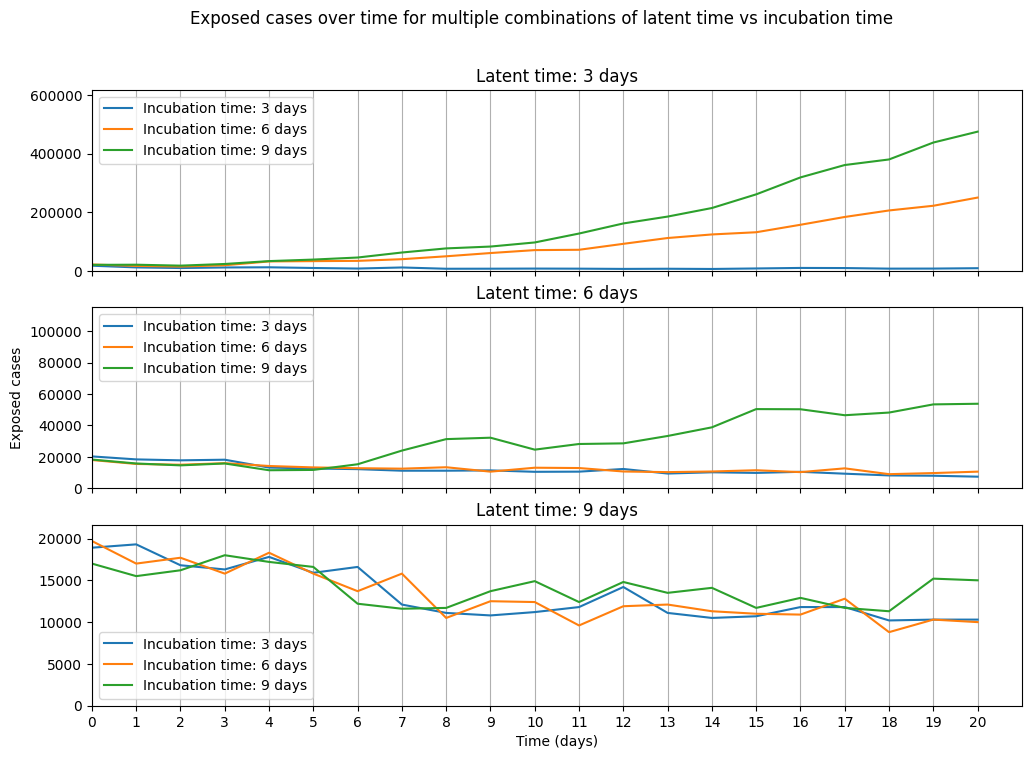

In [33]:
import matplotlib.pyplot as plt

latent_plot_data = [[data for data in agg_data_points if data.latent==latent] for latent in latent_vals]

fig, axs = plt.subplots(3, sharex=True, figsize=(12, 8))

fig.suptitle('Exposed cases over time for multiple combinations of latent time vs incubation time')
axs[1].set_ylabel('Exposed cases')

# Setup x-axis range and labels
x_max = 21 * 24
plt.xlim(0, x_max)
axs[-1].set_xticks(range(0, x_max, 24), labels=range(0, int(x_max/24)))
axs[-1].set_xlabel('Time (days)')

# Plot all the graphs
time_range_daily = np.arange(0, x_max, 24)
for i, plot_data in enumerate(latent_plot_data):
    lines = []

    # Set correct y-range for each graph
    y1_max = np.max([point for data in plot_data for point in data.new_exposed])
    axs[i].set_ylim([0, y1_max * 1.1])
    axs[i].grid(axis='x')
    axs[i].set_title('Latent time: ' + str(plot_data[0].latent) + ' days')

    # Plot the actual values
    for latent_data in plot_data:
        ln1 = axs[i].plot(time_range_daily, latent_data.new_exposed[:21], label='Incubation time: ' + str(latent_data.incub) + ' days')
        lines = lines + ln1

    # Print specific date labels on x-axis
    axs[i].legend(lines, [l.get_label() for l in lines])

axs[1].legend(loc='upper left') # for some reason the second graph had legend in top-right
plt.show()